In [2]:
# Optional, only if you installed Seaborn
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Express Deep Learning in Python - Part 1

Do you have everything ready? Check the part 0!

## How fast can you build a MLP?

In this first part we will see how to implement the basic components of a MultiLayer Perceptron (MLP) classifier, most commonly known as Neural Network. We will be working with the [Keras](https://keras.io/): a very simple library for deep learning.

At this point, you may know how machine learning in general is applied and have some intuitions about how deep learning works, and more importantly, why it works. Now it's time to make some experiments, and for that you need to be as quick and flexible as possible. Keras is an idea tool for prototyping and doing your first approximations to a Machine Learning problem. On the one hand, Keras is integrated with two very powerfull backends that support GPU computations, Tensorflow and Theano. On the other hand, it has a level of abstraction high enough to be simple to understand and easy to use. For example, it uses a very similar interface to the sklearn library that you have seen before, with fit and predict methods.

Now let's get to work with an example:

### 1 - The libraries
Firts let's check we have installed everything we need for this tutorial:

In [3]:
import numpy
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.datasets import mnist

Using TensorFlow backend.


### 2 - The dataset

For this quick tutorial we will use the (very popular) [MNIST dataset](http://yann.lecun.com/exdb/mnist/). This is a dataset of 70K images of handwritten digits. Our task is to recognize which digits is displayed in the image: a **classification** problem. You have seen in previous courses how to train and evaluate a classifier, so we wont talk in further details about supervised learning.

The input to the MLP classifier are going to be images of 28x28 pixels represented as matrixes. The output will be one of ten classes (0 to 9), representing the predicted number written in the image.

In [17]:
batch_size = 128
num_classes = 10
epochs = 10
TRAIN_EXAMPLES = 60000
TEST_EXAMPLES = 10000

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# reshape the dataset to convert the examples from 2D matrixes to 1D arrays.
x_train = x_train.reshape(60000, 28*28)
x_test = x_test.reshape(10000, 28*28)

# to make quick runs, select a smaller set of images.
train_mask = numpy.random.choice(x_train.shape[0], TRAIN_EXAMPLES, replace=False)
x_train = x_train[train_mask, :].astype('float32')
y_train = y_train[train_mask]
test_mask = numpy.random.choice(x_test.shape[0], TEST_EXAMPLES, replace=False)
x_test = x_test[test_mask, :].astype('float32')
y_test = y_test[test_mask]

# normalize the input
x_train /= 255
x_test /= 255

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

### 3 - The model

The concept of Deep Learning is very broad, but the core of it is the use of classifiers with multiple hidden layer of neurons, or smaller classifiers. We all know the classical image of the simplest possible possible deep model: a neural network with a single hidden layer. 

![Neural Network](files/NeuralNetwork.png "Basic Neural Network Architecture")

credits http://www.extremetech.com/wp-content/uploads/2015/07/NeuralNetwork.png

In theory, this model can represent any function ***TODO*** add a citation here. We will see how to implement this network in Keras, and during the second part of this tutorial how to add more features to create a deep and powerful classifier.

First, Deep Learning models are concatenations of Layers. This is represented in Keras with the Sequential model. We create the Sequential instance as an "empty carcass" and then we fill it with different layers. 

The most basic type of Layer is the Dense layer, where each neuron in the input is connected to each neuron in the following layer, like we can see in the image above. Internally, a Dense layer has two variables: a matrix of weights and a vector of bias, but the beauty of Keras is that you don't need to worry about that. All the variables will be correctly created, initialized, trained and possibly regularized for you.

Each layer needs to know or be able to calculate al least three things:

* The size of the input: the number of neurons in the incoming layer. For the first layer this corresponds to the size of each example in our dataset. The next layers can calculate their input size using the output of the previous layer, so we generally don't need to tell them this.
* The type of activation: this is the function that is applied to the output of each neuron. Will talk in detail about this later.
* The size of the output: the number of neurons in the next layer.

In [18]:
model = Sequential()

# Input to hidden layer
model.add(Dense(512, activation='relu', input_shape=(784,)))
# Hidden to output layer
model.add(Dense(10, activation='softmax'))

We have successfully build a Neural Network! We can print a description of our architecture using the following command:

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


#### Compiling a model in Keras

A very appealing aspect of Deep Learning frameworks is that they solve the implementation of complex algorithms such as Backpropagation. For those with some numerical optimization notions, minimization algorithms often involve the calculation of first defivatives. Neural Networks are huge functions full of non-linearities, and differentiating them is a... nightmare. For this reason, models need to be "compiled". In this stage, the backend builds complex computational graphs, and we don't have to worry about derivatives or gradients.

In Keras, a model can be compiled with the method `.compile()`. The method takes two parameters: loss and optimizer. The **loss** is the function that calculates how much error we have in each prediction example, and there are a lot of implemented alternatives ready to use. We will talk more about this, for now we use the standard categorical crossentropy. As you can see, we can simply pass a string with the name of the function and Keras will find the implementation for us.

The **optimizer** is the algorithm to minimize the value of the loss function. Again, Keras has many optimizers available. The basic one is the Stochastic Gradient Descent.

We pass a third argument to the `compile` method: the metric. **Metrics** are measures or statistics that allows us to keep track of the classifier's performance. It's similar to the loss, but the results of the metrics are not use by the optimization algorithm. Besides, metrics are always comparable, while the loss function can take random values depending on your problem.

Keras will calculate metrics and loss both on the training and the validation dataset. That way,  we can monitor how other performance metrics vary when the loss is optimized and detect anomalies like overfitting.

In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])

[OPTIONAL] We can now visualize the architecture of our model using the `vis_util` tools. It's a very schematic view, but you can check it's not that different from the image we saw above (and that we intended to replicate).

If you can't execute this step don't worry, you can still finish the tutorial. This step requires graphviz and pydotplus libraries.

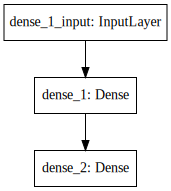

In [8]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

#### Training
Once the model is compiled, everything is ready to train the classifier. Keras' `Sequential` model has a similar interface as the sklearn library that you have seen before, with `fit` and `predict` methods. As usual, we need to pass our training examples and their corresponding labels. Other parameters needed to train a neural network is the size of the batch and the number of epochs. We have two ways of specifying a validation dataset: we can pass the tuple of values and labels directly with the `validation_data` parameter, or we can pass a proportion to the `validation_split` argument and Keras will split the training dataset for us.

To correctly train our model we need to pass two important parameters to the fit function:
 * **batch_size**: is the number of examples to use in each "minibatch" iteration of the Stochastic Gradient Descent algorithm. This is necessary for most optimization algorithms. The size of the batch is important because it defines how fast the algorithm will perform each iteration and also how much memory will be used to load each batch (possibly in the GPU).
 * **epochs**: is the number of passes through the entire dataset. We need enough epochs for the classifier to converge, but we need to stop before the classifier starts overfitting.

In [20]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
          verbose=1, validation_data=(x_test, y_test));

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s - loss: 1.0846 - acc: 0.7632 - val_loss: 0.5846 - val_acc: 0.8705
Epoch 2/10
60000/60000 [==============================] - 5s - loss: 0.5146 - acc: 0.8735 - val_loss: 0.4267 - val_acc: 0.8916
Epoch 3/10
60000/60000 [==============================] - 5s - loss: 0.4162 - acc: 0.8900 - val_loss: 0.3700 - val_acc: 0.9023
Epoch 4/10
60000/60000 [==============================] - 5s - loss: 0.3711 - acc: 0.8997 - val_loss: 0.3372 - val_acc: 0.9093
Epoch 5/10
60000/60000 [==============================] - 5s - loss: 0.3430 - acc: 0.9062 - val_loss: 0.3160 - val_acc: 0.9137
Epoch 6/10
60000/60000 [==============================] - 5s - loss: 0.3231 - acc: 0.9102 - val_loss: 0.3000 - val_acc: 0.9184
Epoch 7/10
60000/60000 [==============================] - 5s - loss: 0.3073 - acc: 0.9146 - val_loss: 0.2884 - val_acc: 0.9202
Epoch 8/10
60000/60000 [==============================] - 5s 

We have trained our model!

Additionally, Keras has printed out a lot of information of the training, thanks to the parameter `verbose=1` that we passed to the fit function. We can see how many time it took in each iteration, and the value of the loss and metrics in the training and the validation dataset. The same information is stored in the output of the fit method, which sadly it's not well documented. We can see it in a pretty table with pandas.

In [21]:
import pandas
pandas.DataFrame(history.history)

,acc,loss,val_acc,val_loss
0,0.763167,1.084637,0.8705,0.584608
1,0.873550,0.514642,0.8916,0.426674
2,0.889967,0.416233,0.9023,0.369997
3,0.899683,0.371069,0.9093,0.337219
4,0.906250,0.342993,0.9137,0.315957
5,0.910233,0.323086,0.9184,0.299992
6,0.914567,0.307324,0.9202,0.288381
7,0.918150,0.294214,0.9244,0.277729
8,0.921567,0.283129,0.9272,0.267816
9,0.923733,0.273049,0.9281,0.259294


Why is this useful? This will give you an insight on how well your network is optimizing the loss, and how much it's actually learning. When training, you need to keep track of two things:

* Your network is actually learning. This means your training loss is decreasing in average. If it's going up or it's stuck for more than a couple of epochs is safe to stop you training and try again.
* You network is not overfitting. It's normal to have a gap between the validation and the training metrics, but they should decrease more or less at the same rate. If you see that your metrics for training are getting better but your validation metrics are getting worse, it is also a good point to stop and fix your overfitting problem.

#### Evaluation

Keras gives us a very useful method to evaluate the current performance called `evaluate` (surprise!). Evaluate will return the value of the loss function and all the metrics that we pass to the model when calling compile.

In [11]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.09052189354
Test accuracy: 0.9738


As you can see, using only 10 training epochs we get a very surprising accuracy in the training and test dataset. If you want to take a deeper look into your model, you can obtain the predictions as a vector and then use general purpose tools to explore the results. For example, we can plot the confusion matrix to see the most common errors.

In [22]:
prediction = model.predict_classes(x_test)

 9312/10000 [==========================>...] - ETA: 0s

In [39]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.set_style('white')
sns.set_palette('colorblind')

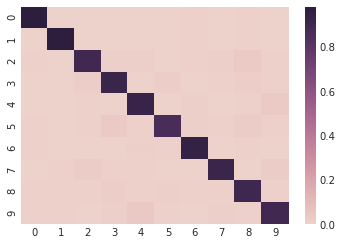

In [59]:
matrix = confusion_matrix(numpy.argmax(y_test, 1), prediction)
figure = sns.heatmap(matrix / matrix.astype(numpy.float).sum(axis=1), 
                     xticklabels=range(10), yticklabels=range(10),
                     cmap=sns.cubehelix_palette(8,  as_cmap=True))

We can see that the model is still confusing some numbers. For example, 4s and 9s, or 3s and 8s. This may be happening because our model is trained with very few epochs, but most likely it happens because our model is too simple and can't generalize to unseen data. In the following part of the tutorial, we will see the details of more complex components of neural classifiers and how to use them to build a more powerful classifier.